In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [18]:
data = pd.read_csv('data/data.csv')

In [3]:
data.head(10)

,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers,month,week_of_year,quarter,day_of_year,subscriber_ratio,is_summer,is_winter,is_spring,is_fall
0,2024-04-15,FB,82,0,0,483,167.0,4,16,2,106,2.875000,0,0,1,0
1,2024-04-22,FB,90,0,0,453,176.0,4,17,2,113,2.559322,0,0,1,0
2,2024-04-29,FB,80,0,0,501,173.0,4,18,2,120,2.879310,0,0,1,0
3,2024-05-06,FB,94,1,0,556,170.0,5,19,2,127,3.251462,0,0,1,0
4,2024-05-13,FB,65,0,1,546,174.0,5,20,2,134,3.120000,0,0,1,0
5,2024-05-20,FB,97,1,0,510,179.0,5,21,2,141,2.833333,0,0,1,0
6,2024-05-27,FB,79,0,0,544,168.0,5,22,2,148,3.218935,0,0,1,0
7,2024-06-03,FB,90,0,0,561,159.0,6,23,2,155,3.506250,1,0,0,0
8,2024-06-10,FB,87,0,0,554,157.0,6,24,2,162,3.506329,1,0,0,0
9,2024-06-17,FB,97,0,0,548,165.0,6,25,2,169,3.301205,1,0,0,0


In [20]:
from src.Analysis import *
data_analysis(data)


Dataset shape: (416, 16)
Missing values:
week                       0
box_type                   0
box_orders                 0
is_marketing_week          0
holiday_week               0
weekly_subscribers         0
fortnightly_subscribers    0
month                      0
week_of_year               0
quarter                    0
day_of_year                0
subscriber_ratio           0
is_summer                  0
is_winter                  0
is_spring                  0
is_fall                    0
dtype: int64
Data types:
week                       datetime64[ns]
box_type                           object
box_orders                          int64
is_marketing_week                   int64
holiday_week                        int64
weekly_subscribers                  int64
fortnightly_subscribers           float64
month                               int64
week_of_year                        int64
quarter                             int64
day_of_year                         int64
subscrib

In [23]:
# seasonal_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import holidays
from datetime import datetime, timedelta
import joblib

class SeasonalAnalyzer:
    """
    Class for analyzing and modeling seasonal patterns in box order data
    """
    def __init__(self, data_path=None, df=None):
        """
        Initialize with either a path to data or a DataFrame
        """
        if df is not None:
            self.df = df.copy()
        elif data_path:
            self.df = pd.read_csv(data_path)
            # Convert week to datetime if it exists
            if 'week' in self.df.columns:
                self.df['week'] = pd.to_datetime(self.df['week'])
        else:
            raise ValueError("Either data_path or df must be provided")
        
        # Initialize UK holidays
        self.uk_holidays = holidays.UK()
        
    def add_holiday_features(self):
        """
        Add holiday-related features to the dataset
        """
        # Check if week column exists
        date_col = 'week' if 'week' in self.df.columns else 'date'
        
        # Ensure date column is datetime
        if not pd.api.types.is_datetime64_any_dtype(self.df[date_col]):
            self.df[date_col] = pd.to_datetime(self.df[date_col])
        
        # Add is_holiday flag - convert pandas Timestamp to datetime date for comparison
        self.df['is_holiday'] = self.df[date_col].apply(
            lambda x: 1 if x.date() in self.uk_holidays else 0
        )
        
        # Add days_to_holiday feature (days to next holiday)
        def days_to_next_holiday(date):
            # Convert pandas Timestamp to datetime date
            date_as_date = date.date()
            # Get future holidays as datetime.date objects
            future_holidays = [h for h in self.uk_holidays.keys() if h >= date_as_date]
            if future_holidays:
                next_holiday = min(future_holidays)
                return (next_holiday - date_as_date).days
            return 30  # Default if no upcoming holiday found
            
        self.df['days_to_holiday'] = self.df[date_col].apply(days_to_next_holiday)
        
        # Add days_from_holiday feature (days since last holiday)
        def days_from_last_holiday(date):
            # Convert pandas Timestamp to datetime date
            date_as_date = date.date()
            # Get past holidays as datetime.date objects
            past_holidays = [h for h in self.uk_holidays.keys() if h <= date_as_date]
            if past_holidays:
                last_holiday = max(past_holidays)
                return (date_as_date - last_holiday).days
            return 30  # Default if no previous holiday found
            
        self.df['days_from_holiday'] = self.df[date_col].apply(days_from_last_holiday)
        
        # Add holiday_season flags
        self.df['is_christmas_season'] = self.df[date_col].apply(
            lambda x: 1 if (x.month == 12 or (x.month == 1 and x.day < 15)) else 0
        )
        self.df['is_easter_season'] = self.df[date_col].apply(
            lambda x: 1 if (x.month in [3, 4] and (x.day > 15 if x.month == 3 else x.day < 15)) else 0
        )
        self.df['is_summer_holiday'] = self.df[date_col].apply(
            lambda x: 1 if (x.month in [7, 8]) else 0
        )
        
        return self.df
    
    def add_cyclical_features(self):
        """
        Add cyclical time features using sine and cosine transformations
        """
        # Check if week column exists
        date_col = 'week' if 'week' in self.df.columns else 'date'
        
        # Ensure date column is datetime
        if not pd.api.types.is_datetime64_any_dtype(self.df[date_col]):
            self.df[date_col] = pd.to_datetime(self.df[date_col])
        
        # Day of week (0-6) -> cyclical feature
        self.df['day_of_week'] = self.df[date_col].dt.dayofweek
        self.df['day_of_week_sin'] = np.sin(2 * np.pi * self.df['day_of_week'] / 7)
        self.df['day_of_week_cos'] = np.cos(2 * np.pi * self.df['day_of_week'] / 7)
        
        # Month (1-12) -> cyclical feature
        self.df['month'] = self.df[date_col].dt.month
        self.df['month_sin'] = np.sin(2 * np.pi * self.df['month'] / 12)
        self.df['month_cos'] = np.cos(2 * np.pi * self.df['month'] / 12)
        
        # Week of year (1-53) -> cyclical feature
        self.df['week_of_year'] = self.df[date_col].dt.isocalendar().week
        self.df['week_of_year_sin'] = np.sin(2 * np.pi * self.df['week_of_year'] / 53)
        self.df['week_of_year_cos'] = np.cos(2 * np.pi * self.df['week_of_year'] / 53)
        
        return self.df
    
    
    def decompose_time_series(self, box_type=None, target_col='box_orders', period=None):

    # Filter data if box_type is provided
        if box_type:
            data = self.df[self.df['box_type'] == box_type].copy()
        else:
            data = self.df.copy()

        # Sort by date
        date_col = 'week' if 'week' in data.columns else 'date'
        data = data.sort_values(date_col)

        # Set date as index
        data = data.set_index(date_col)

        # Determine appropriate period if not specified
        if period is None:
            # For weekly data, use 26 (half year) if we have enough data
            if len(data) >= 52:
                period = 26
            elif len(data) >= 24:
                # For shorter datasets, use quarter
                period = 13
            else:
                # For very short datasets, use month
                period = 4

        # Check if we have enough data for decomposition (need 2*period observations)
        if len(data) < 2 * period:
            print(f"Warning: Not enough data for decomposition with period={period}. Need {2*period} observations, but only have {len(data)}.")
            print("Reducing period to allow decomposition.")
            period = len(data) // 2  # Use half the data length as period
            if period < 2:
                print("Insufficient data for meaningful decomposition. Skipping.")
                # Initialize component columns anyway
                self.df['trend'] = np.nan
                self.df['seasonal'] = np.nan
                self.df['residual'] = np.nan
                return None

        try:
            # Perform decomposition
            result = seasonal_decompose(
                data[target_col], 
                model='multiplicative', 
                period=period,
                extrapolate_trend='freq'
            )
            
            # Store components in the dataframe
            self.df['trend'] = np.nan
            self.df['seasonal'] = np.nan
            self.df['residual'] = np.nan
            
            if box_type:
                mask = self.df['box_type'] == box_type
                self.df.loc[mask, 'trend'] = result.trend.values
                self.df.loc[mask, 'seasonal'] = result.seasonal.values
                self.df.loc[mask, 'residual'] = result.resid.values
            else:
                self.df['trend'] = result.trend.values
                self.df['seasonal'] = result.seasonal.values
                self.df['residual'] = result.resid.values
            
            return result

        except Exception as e:
            print(f"Error in decomposition: {e}")
            # Initialize component columns anyway
            self.df['trend'] = np.nan
            self.df['seasonal'] = np.nan
            self.df['residual'] = np.nan
            return None
    
    def plot_seasonal_patterns(self, box_type=None, target_col='box_orders'):
        """
        Create visualizations of seasonal patterns
        
        Parameters:
        -----------
        box_type : str, optional
            If provided, analyze only data for this box type
        target_col : str
            Column name for the target variable
        """
        # Filter data if box_type is provided
        if box_type:
            data = self.df[self.df['box_type'] == box_type].copy()
        else:
            data = self.df.copy()
        
        # Create figure with subplots
        fig, axes = plt.subplots(3, 1, figsize=(15, 18))
        
        # 1. Monthly patterns
        monthly_avg = data.groupby('month')[target_col].mean()
        axes[0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2)
        axes[0].set_title(f'Monthly Pattern - {"All Box Types" if not box_type else box_type}', fontsize=16)
        axes[0].set_xlabel('Month', fontsize=12)
        axes[0].set_ylabel('Average Orders', fontsize=12)
        axes[0].set_xticks(range(1, 13))
        axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        axes[0].grid(True)
        
        # 2. Day of week patterns
        if 'day_of_week' in data.columns:
            dow_avg = data.groupby('day_of_week')[target_col].mean()
            axes[1].plot(dow_avg.index, dow_avg.values, marker='o', linewidth=2)
            axes[1].set_title(f'Day of Week Pattern - {"All Box Types" if not box_type else box_type}', fontsize=16)
            axes[1].set_xlabel('Day of Week', fontsize=12)
            axes[1].set_ylabel('Average Orders', fontsize=12)
            axes[1].set_xticks(range(7))
            axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
            axes[1].grid(True)
        
        # 3. Week of year patterns
        if 'week_of_year' in data.columns:
            wow_avg = data.groupby('week_of_year')[target_col].mean()
            axes[2].plot(wow_avg.index, wow_avg.values, marker='.', linewidth=1)
            axes[2].set_title(f'Week of Year Pattern - {"All Box Types" if not box_type else box_type}', fontsize=16)
            axes[2].set_xlabel('Week of Year', fontsize=12)
            axes[2].set_ylabel('Average Orders', fontsize=12)
            axes[2].grid(True)
        
        plt.tight_layout()
        plt.savefig(f'seasonal_patterns_{"all" if not box_type else box_type}.png')
        plt.close()
        
        # Create heatmap for day-of-week vs month
        if 'day_of_week' in data.columns and 'month' in data.columns:
            pivot_data = data.pivot_table(
                index='day_of_week', 
                columns='month', 
                values=target_col,
                aggfunc='mean'
            )
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.1f')
            plt.title(f'Average Orders by Day of Week and Month - {"All Box Types" if not box_type else box_type}', fontsize=16)
            plt.xlabel('Month', fontsize=12)
            plt.ylabel('Day of Week', fontsize=12)
            plt.yticks(np.arange(7) + 0.5, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
            plt.xticks(np.arange(12) + 0.5, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.tight_layout()
            plt.savefig(f'seasonal_heatmap_{"all" if not box_type else box_type}.png')
            plt.close()
    
    def fit_sarima_model(self, box_type, order=(1,1,1), seasonal_order=(1,1,1,52)):
        """
        Fit a SARIMA model for a specific box type
        
        Parameters:
        -----------
        box_type : str
            Box type to model
        order : tuple
            (p,d,q) order for the non-seasonal part of the model
        seasonal_order : tuple
            (P,D,Q,s) order for the seasonal part of the model
            
        Returns:
        --------
        model : SARIMAX model
            Fitted SARIMA model
        """
        # Filter data for the specified box type
        data = self.df[self.df['box_type'] == box_type].copy()
        
        # Sort by date
        date_col = 'week' if 'week' in data.columns else 'date'
        data = data.sort_values(date_col)
        
        # Set date as index
        data = data.set_index(date_col)
        
        # Fit SARIMA model
        model = SARIMAX(
            data['box_orders'],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False)
        print(f"SARIMA model for {box_type} - AIC: {results.aic}")
        
        # Save the model
        joblib.dump(results, f'sarima_model_{box_type}.pkl')
        
        return results
    
    def calculate_seasonal_importance(self):
        """
        Calculate the importance of seasonality in explaining the variance
        
        Returns:
        --------
        dict : Dictionary with seasonal importance metrics
        """
        # Check if decomposition has been performed
        if 'trend' not in self.df.columns or 'seasonal' not in self.df.columns:
            print("Time series decomposition not performed yet. Running with default parameters.")
            self.decompose_time_series()
        
        # Calculate variance of each component
        total_variance = self.df['box_orders'].var()
        trend_variance = self.df['trend'].var()
        seasonal_variance = self.df['seasonal'].var()
        residual_variance = self.df['residual'].var()
        
        # Calculate proportion of variance explained by each component
        trend_importance = trend_variance / total_variance
        seasonal_importance = seasonal_variance / total_variance
        residual_importance = residual_variance / total_variance
        
        # Calculate by box type if available
        box_type_importance = {}
        if 'box_type' in self.df.columns:
            for box_type in self.df['box_type'].unique():
                box_data = self.df[self.df['box_type'] == box_type]
                
                box_total_var = box_data['box_orders'].var()
                box_trend_var = box_data['trend'].var()
                box_seasonal_var = box_data['seasonal'].var()
                box_residual_var = box_data['residual'].var()
                
                box_type_importance[box_type] = {
                    'trend_importance': box_trend_var / box_total_var,
                    'seasonal_importance': box_seasonal_var / box_total_var,
                    'residual_importance': box_residual_var / box_total_var
                }
        
        return {
            'overall': {
                'trend_importance': trend_importance,
                'seasonal_importance': seasonal_importance,
                'residual_importance': residual_importance
            },
            'by_box_type': box_type_importance
        }
    
    def generate_seasonal_features(self, future_dates=None, periods=52):
        """
        Generate seasonal features for future dates
        
        Parameters:
        -----------
        future_dates : list or array, optional
            List of future dates to generate features for
        periods : int
            Number of future periods to generate if future_dates not provided
            
        Returns:
        --------
        DataFrame : DataFrame with seasonal features for future dates
        """
        # Get the last date in the dataset
        date_col = 'week' if 'week' in self.df.columns else 'date'
        last_date = self.df[date_col].max()
        
        # Generate future dates if not provided
        if future_dates is None:
            future_dates = [last_date + timedelta(weeks=i+1) for i in range(periods)]
        
        # Create DataFrame with future dates
        future_df = pd.DataFrame({date_col: future_dates})
        
        # Add cyclical features
        future_df['day_of_week'] = future_df[date_col].dt.dayofweek
        future_df['day_of_week_sin'] = np.sin(2 * np.pi * future_df['day_of_week'] / 7)
        future_df['day_of_week_cos'] = np.cos(2 * np.pi * future_df['day_of_week'] / 7)
        
        future_df['month'] = future_df[date_col].dt.month
        future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
        future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
        
        future_df['week_of_year'] = future_df[date_col].dt.isocalendar().week
        future_df['week_of_year_sin'] = np.sin(2 * np.pi * future_df['week_of_year'] / 53)
        future_df['week_of_year_cos'] = np.cos(2 * np.pi * future_df['week_of_year'] / 53)
        
        # Add holiday features
        future_df['is_holiday'] = future_df[date_col].apply(lambda x: 1 if x in self.uk_holidays else 0)
        
        # Add holiday season flags
        future_df['is_christmas_season'] = future_df[date_col].apply(
            lambda x: 1 if (x.month == 12 or (x.month == 1 and x.day < 15)) else 0
        )
        future_df['is_easter_season'] = future_df[date_col].apply(
            lambda x: 1 if (x.month in [3, 4] and (x.day > 15 if x.month == 3 else x.day < 15)) else 0
        )
        future_df['is_summer_holiday'] = future_df[date_col].apply(
            lambda x: 1 if (x.month in [7, 8]) else 0
        )
        
        return future_df


# Initialize analyzer with data
analyzer = SeasonalAnalyzer(data_path='data/data.csv')

# Add holiday and cyclical features
analyzer.add_holiday_features()
analyzer.add_cyclical_features()

# Decompose time series for each box type
for box_type in analyzer.df['box_type'].unique():
    print(f"Decomposing time series for {box_type}")
    result = analyzer.decompose_time_series(box_type=box_type)
    
    # Plot decomposition
    plt.figure(figsize=(12, 10))
    result.plot()
    plt.suptitle(f'Time Series Decomposition - {box_type}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig(f'decomposition_{box_type}.png')
    plt.close()
    
    # Plot seasonal patterns
    analyzer.plot_seasonal_patterns(box_type=box_type)
    
    # Fit SARIMA model
    analyzer.fit_sarima_model(box_type=box_type)

# Calculate seasonal importance
importance = analyzer.calculate_seasonal_importance()
print("\nSeasonal Importance:")
print(f"Overall: {importance['overall']['seasonal_importance']:.2%}")

for box_type, metrics in importance['by_box_type'].items():
    print(f"{box_type}: {metrics['seasonal_importance']:.2%}")

# Generate seasonal features for future dates
future_features = analyzer.generate_seasonal_features(periods=12)
print("\nSeasonal features for future dates:")
print(future_features.head())




Decomposing time series for FB
SARIMA model for FB - AIC: 10.0
Decomposing time series for LFV
SARIMA model for LFV - AIC: 10.0
Decomposing time series for LV
SARIMA model for LV - AIC: 10.0
Decomposing time series for MFV
SARIMA model for MFV - AIC: 10.0
Decomposing time series for MV
SARIMA model for MV - AIC: 10.0
Decomposing time series for SFV
SARIMA model for SFV - AIC: 10.0
Decomposing time series for SV
SARIMA model for SV - AIC: 10.0
Decomposing time series for XSFV
SARIMA model for XSFV - AIC: 10.0

Seasonal Importance:
Overall: 0.01%
FB: nan%
LFV: nan%
LV: nan%
MFV: nan%
MV: nan%
SFV: nan%
SV: nan%
XSFV: 0.01%

Seasonal features for future dates:
        week  day_of_week  day_of_week_sin  day_of_week_cos  month  month_sin  \
0 2025-04-14            0              0.0              1.0      4   0.866025   
1 2025-04-21            0              0.0              1.0      4   0.866025   
2 2025-04-28            0              0.0              1.0      4   0.866025   
3 2025-05-

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [4]:
from data_process import process_data

feature_engineered_data = process_data('data.csv')



Raw data shape: (416, 16)
Performing feature engineering...
Processing features for box type: FB
Processing features for box type: LFV
Processing features for box type: LV
Processing features for box type: MFV
Processing features for box type: MV
Processing features for box type: SFV
Processing features for box type: SV
Processing features for box type: XSFV

Processed data saved to data.csv
Final data shape: (416, 16)


/Users/xinzhang/Codes/Oddbox/data_process.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['weekly_subscribers'] = df['weekly_subscribers'].fillna(method='ffill')


In [5]:
from train_model import train_and_evaluate_models

/Users/xinzhang/.pyenv/versions/realtime_interview_copilot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from train_global_model import train_global_model



Training global models for all box types...

Performing feature selection based on correlation...
Feature correlation heatmap saved as feature_correlation_heatmap.png
Removing 6 highly correlated features: ['week_of_year', 'quarter', 'day_of_year', 'rolling_mean_8', 'rolling_min_4', 'rolling_max_4']
Selected 24 features after correlation filtering
Checking for NaN values in features...

Training RandomForest model...
RandomForest model performance: MAE = 7.57, RMSE = 9.27, MAPE = 9.57%

Top 10 most important features:
                    Feature  Importance
22           rolling_mean_4    0.581689
23            rolling_std_4    0.078021
2        weekly_subscribers    0.046422
3   fortnightly_subscribers    0.045969
18                    lag_1    0.044342
19                    lag_2    0.037787
0         is_marketing_week    0.037395
20                    lag_3    0.037331
21                    lag_4    0.023708
5          subscriber_ratio    0.019126

Training GradientBoosting model...

09:03:52 - cmdstanpy - INFO - Chain [1] start processing
09:03:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet model performance: MAE = 2928.01, RMSE = 3768.63, MAPE = 458.66%

Best model: RandomForest (Type: ML)
MAE: 7.57
RMSE: 9.27
MAPE: 9.57%
Historical proportion for FB: 12.43%
Historical proportion for LFV: 12.43%
Historical proportion for LV: 12.78%
Historical proportion for MFV: 12.44%
Historical proportion for MV: 12.57%
Historical proportion for SFV: 12.47%
Historical proportion for SV: 12.43%
Historical proportion for XSFV: 12.44%

Generating forecast for FB...

Generating forecast for LFV...

Generating forecast for LV...

Generating forecast for MFV...

Generating forecast for MV...

Generating forecast for SFV...

Generating forecast for SV...

Generating forecast for XSFV...
Detailed box type predictions visualization saved as box_type_predictions_detail.png

Total forecasted box demand for next 4 weeks:
week_1: 643 boxes
week_2: 646 boxes
week_3: 634 boxes
week_4: 634 boxes

Forecast results saved to 'box_demand_forecast.csv' and 'box_demand_forecast_pivot.csv'
Feature im

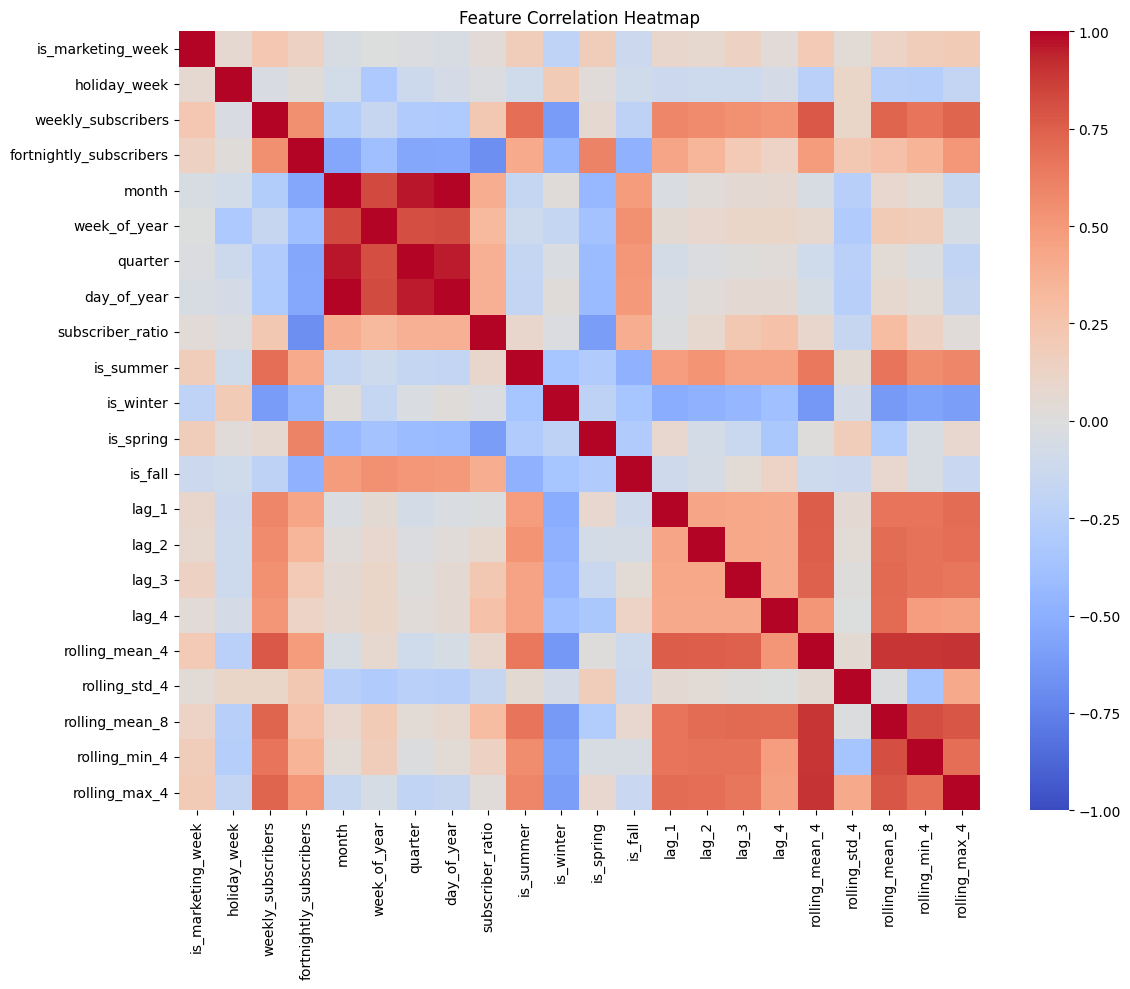

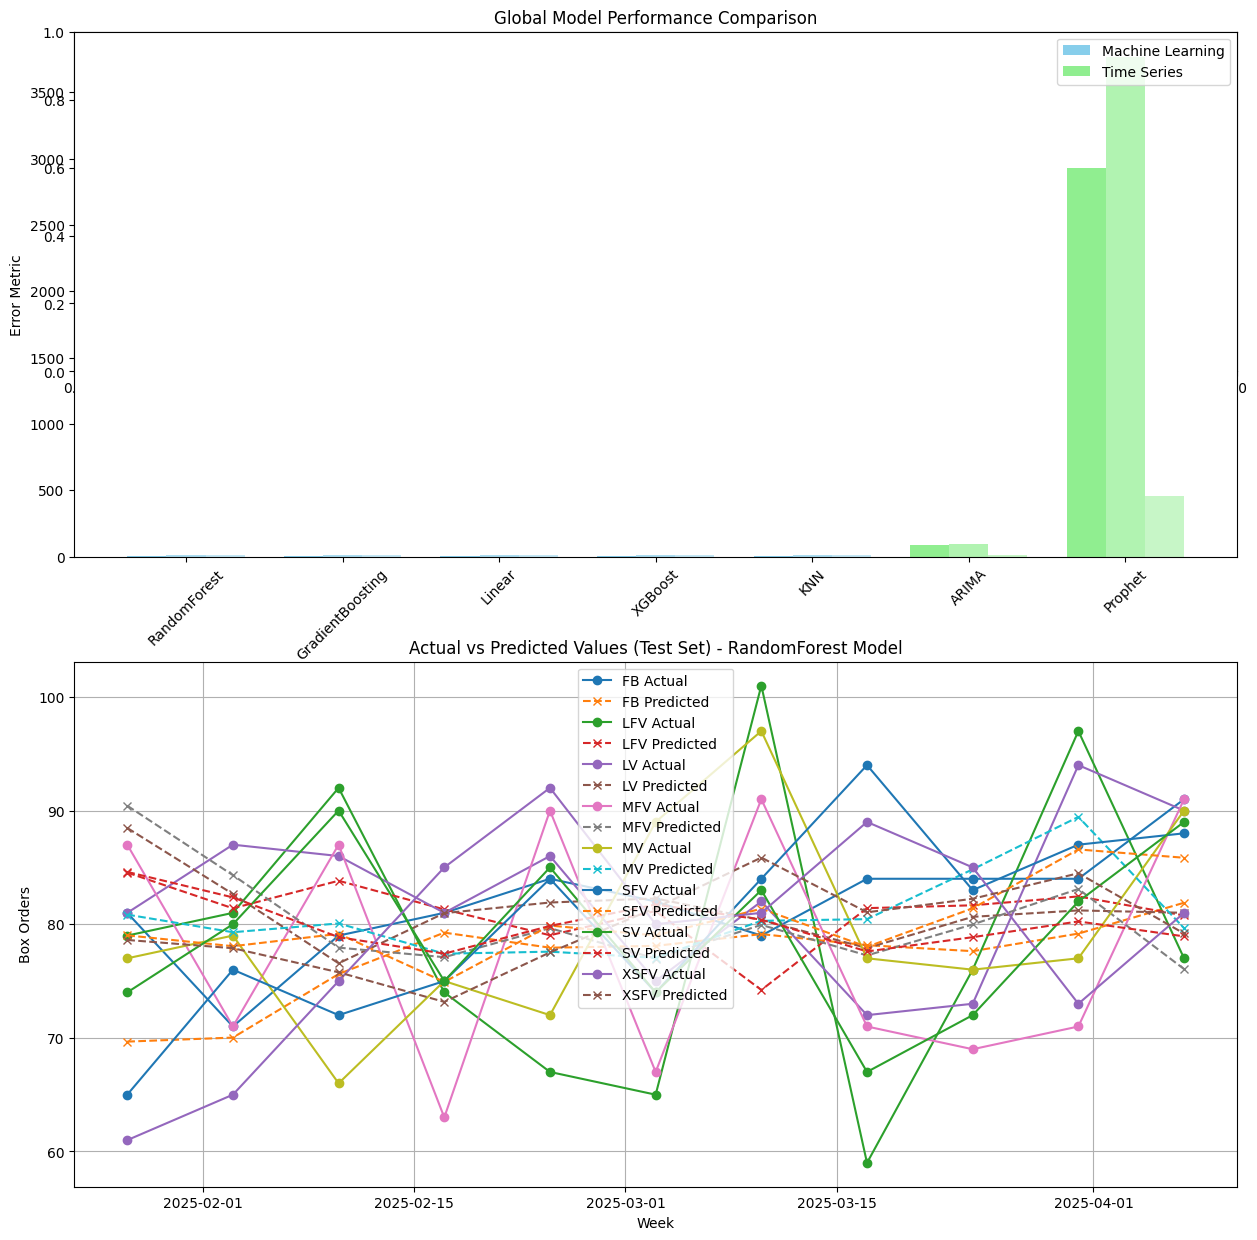

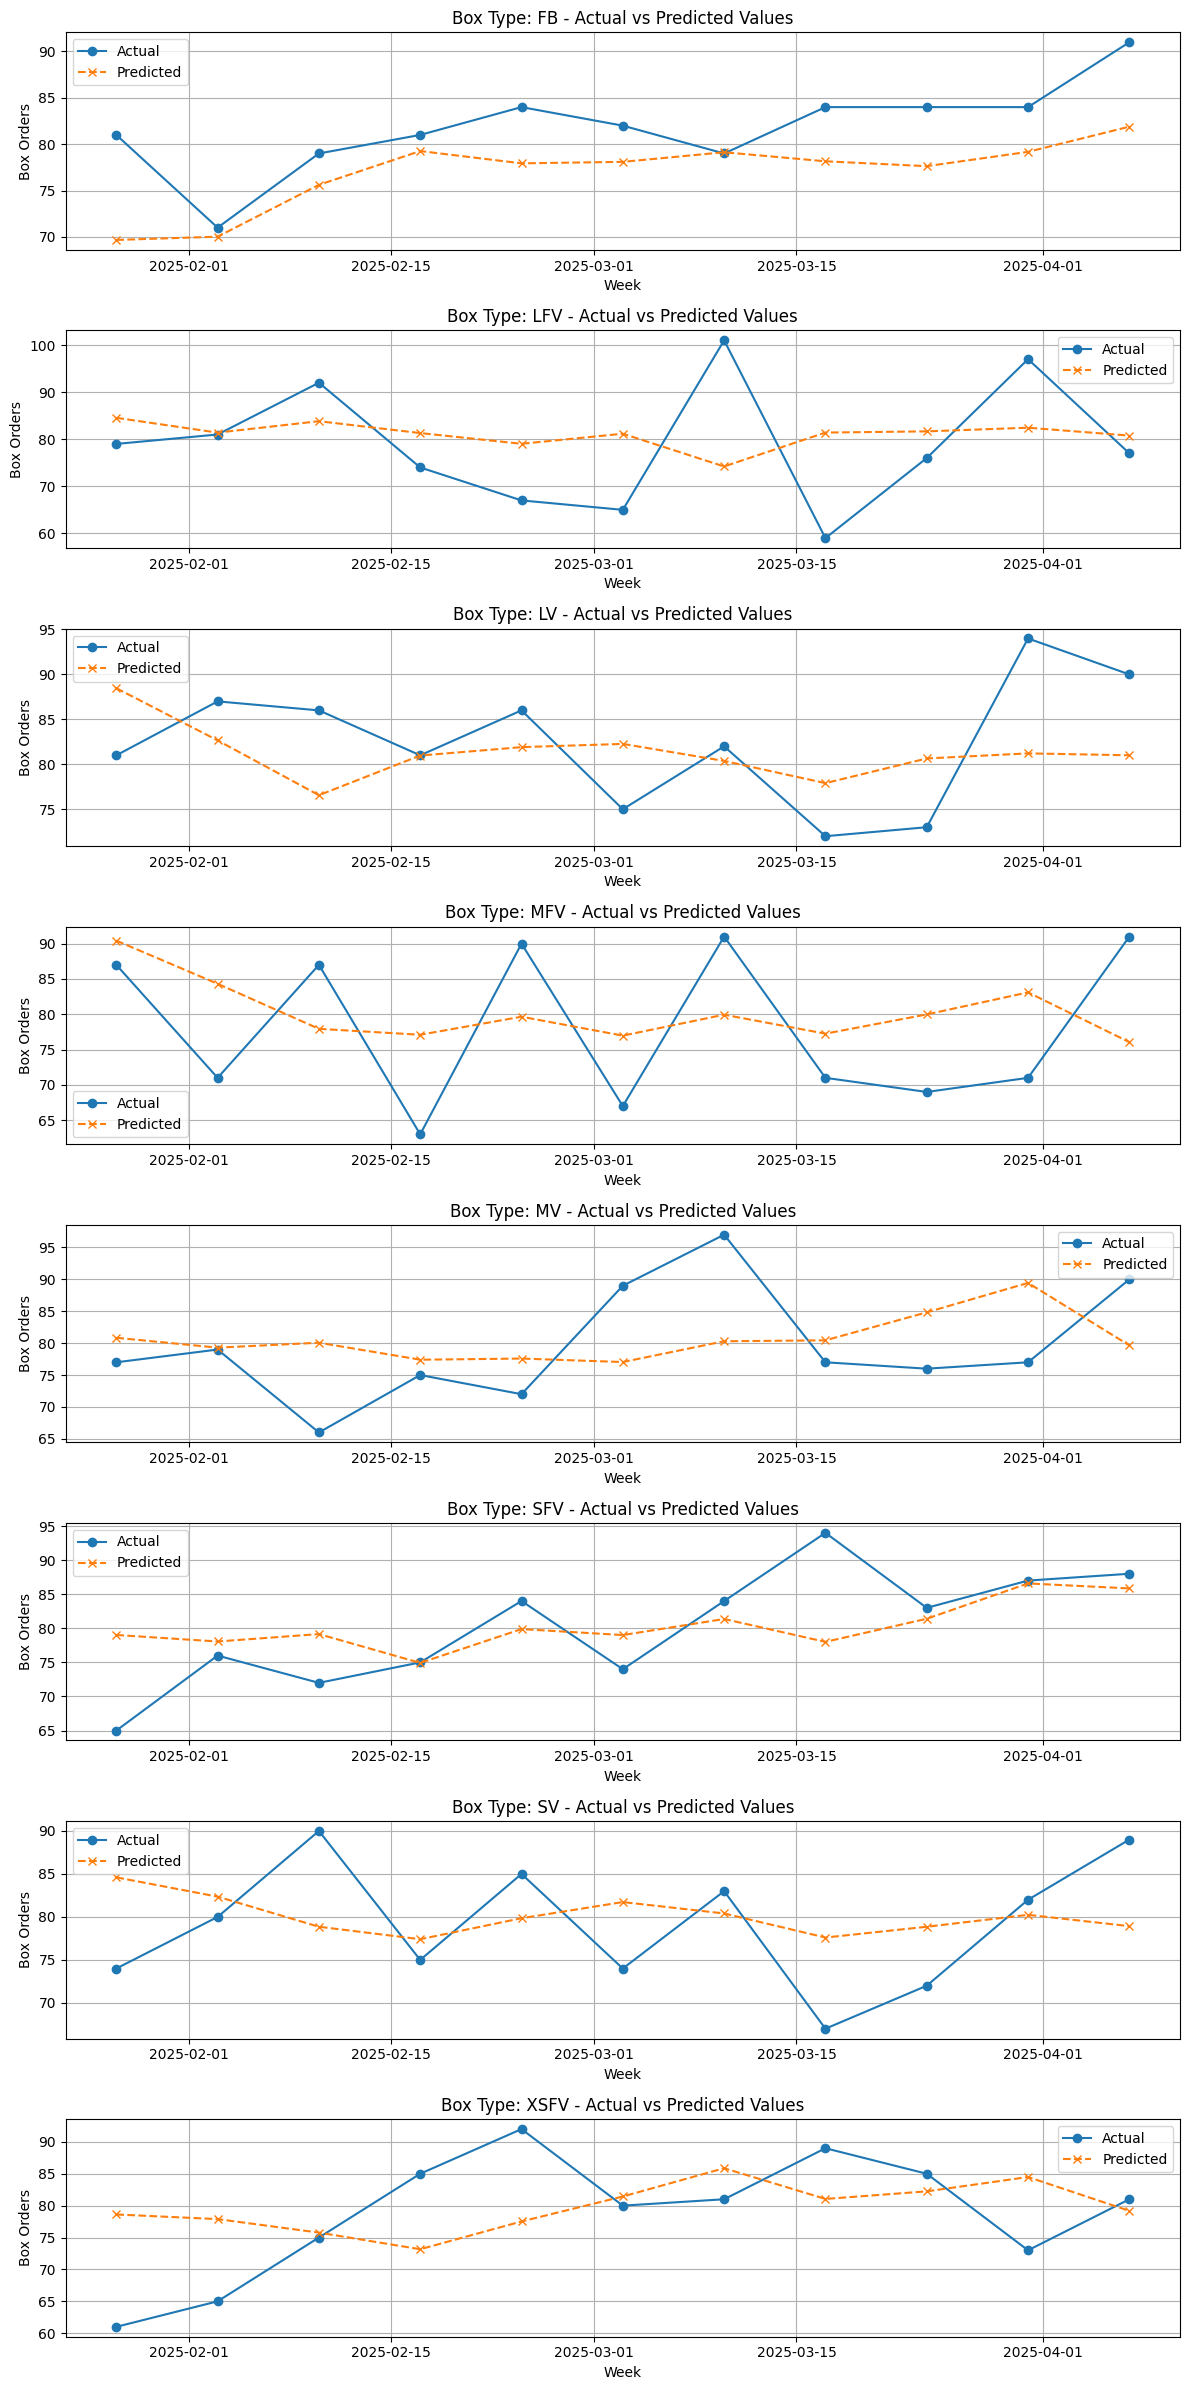

<Figure size 1500x1500 with 0 Axes>

In [9]:
model, results, feature_importance = train_global_model(df)

# Create forecast summary
forecast_summary = []
for box_type, forecast_values in results['forecasts'].items():
    for i, value in enumerate(forecast_values):
        forecast_summary.append({
            'box_type': box_type,
            'model': 'GlobalRandomForest',
            'forecast_week': i+1,
            'forecast_value': value,
            'mae': results['mae'],
            'rmse': results['rmse']
        })

# Create forecast summary dataframe
forecast_df = pd.DataFrame(forecast_summary)
forecast_df.to_csv('box_demand_forecast.csv', index=False)

# Create pivot table for easier reading
forecast_pivot = forecast_df.pivot_table(
    index=['box_type', 'model', 'mae', 'rmse'], 
    columns='forecast_week', 
    values='forecast_value'
)
forecast_pivot.columns = [f'Week {i}' for i in forecast_pivot.columns]
forecast_pivot.to_csv('box_demand_forecast_pivot.csv')

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

# Calculate total forecasted demand for next 4 weeks
total_forecast = {}
for week in range(1, 5):
    week_data = forecast_df[forecast_df['forecast_week'] == week]
    total_forecast[f'week_{week}'] = week_data['forecast_value'].sum()

print("\nTotal forecasted box demand for next 4 weeks:")
for week, total in total_forecast.items():
    print(f"{week}: {total:.0f} boxes")

print("\nForecast results saved to 'box_demand_forecast.csv' and 'box_demand_forecast_pivot.csv'")
print("Feature importance saved to 'feature_importance.csv'")

In [10]:
model

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [11]:
results['forecasts']

{'FB': [np.float64(81.89),
  np.float64(82.155),
  np.float64(82.45),
  np.float64(82.465)],
 'LFV': [np.float64(80.77),
  np.float64(82.065),
  np.float64(77.93),
  np.float64(77.45)],
 'LV': [np.float64(81.005),
  np.float64(82.125),
  np.float64(78.185),
  np.float64(78.265)],
 'MFV': [np.float64(76.055),
  np.float64(75.81),
  np.float64(74.83),
  np.float64(77.18)],
 'MV': [np.float64(79.655),
  np.float64(78.625),
  np.float64(78.07),
  np.float64(78.47)],
 'SFV': [np.float64(85.85),
  np.float64(85.98),
  np.float64(84.665),
  np.float64(83.325)],
 'SV': [np.float64(78.93),
  np.float64(80.255),
  np.float64(77.995),
  np.float64(78.685)],
 'XSFV': [np.float64(79.185),
  np.float64(78.57),
  np.float64(79.725),
  np.float64(78.305)]}


Performing feature selection based on correlation...
Feature correlation heatmap saved as feature_correlation_heatmap.png
Removing 6 highly correlated features: ['week_of_year', 'quarter', 'day_of_year', 'rolling_mean_8', 'rolling_min_4', 'rolling_max_4']
Selected 24 features after correlation filtering
Checking for NaN values in features...
Starting GradientBoosting model fine-tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.1}
Best MAE score: 4.96
Tuned GradientBoosting performance: MAE = 7.25, RMSE = 8.96, MAPE = 9.31%
Default GradientBoosting performance: MAE = 7.59, RMSE = 9.23, MAPE = 9.68%
Best model saved as 'best_gradient_boosting_model.pkl'
Feature importance visualization saved as 'gb_feature_importance.png'
Actual vs Predicted visualization saved as 'gb_actual_vs_predicted.png'

Fine-tu

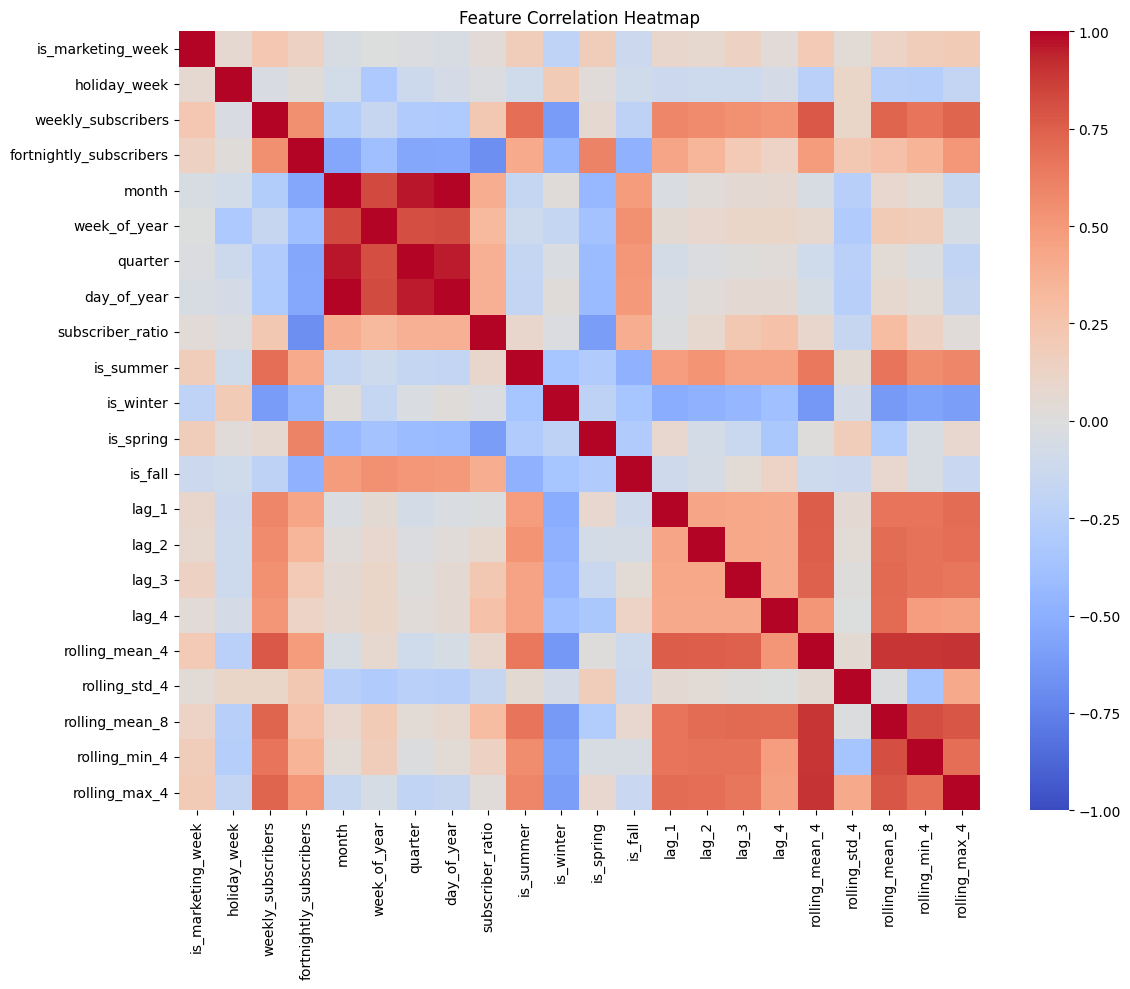

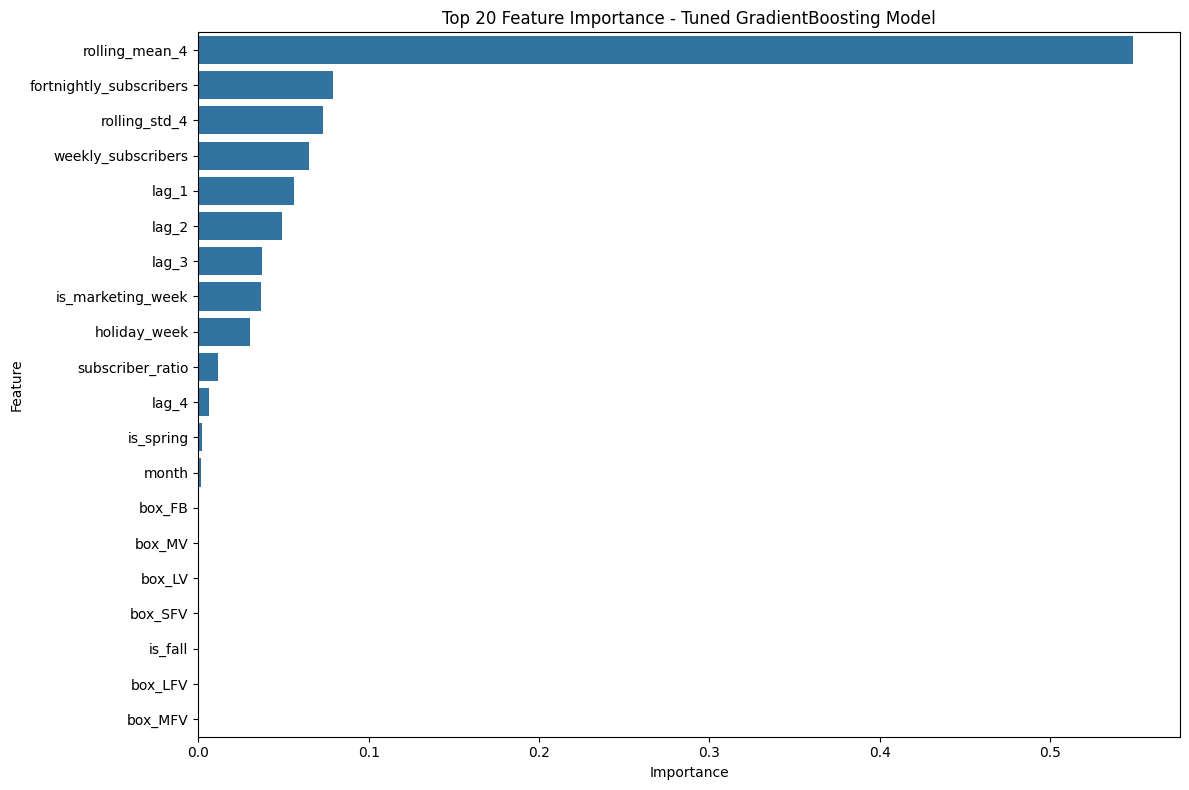

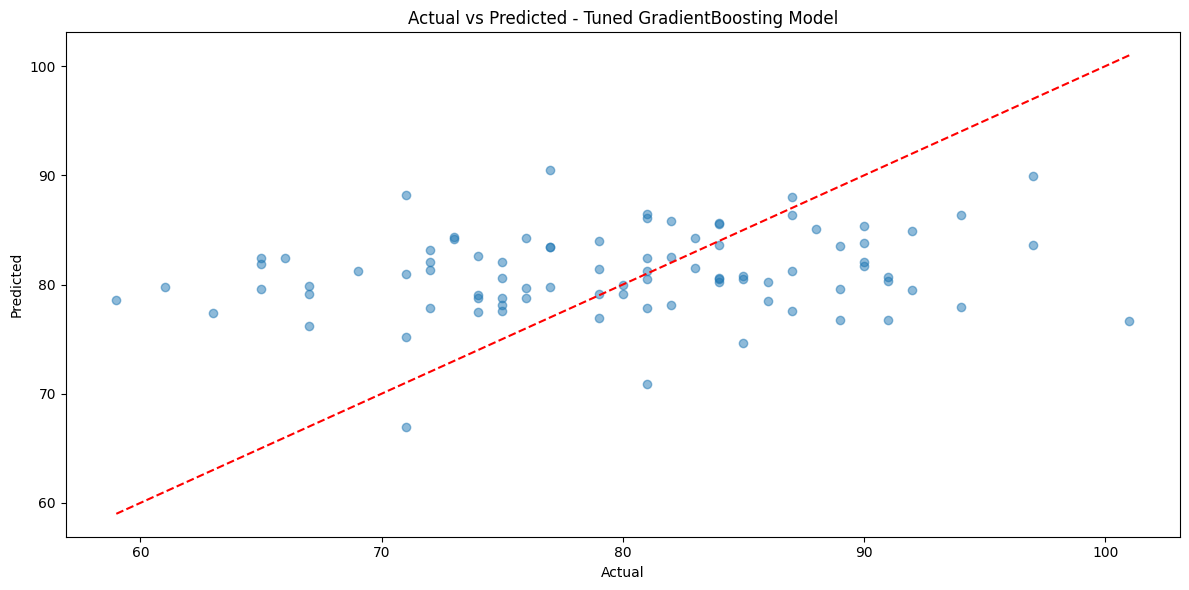

In [12]:
from fine_tune_gb import fine_tune_gradient_boosting
from train_global_model import * 
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test, feature_names, _, _ = feature_engineering(df)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
best_model, metrics = fine_tune_gradient_boosting(X_train_scaled, y_train, X_test_scaled, y_test, feature_names)
# Print summary
print("\nFine-tuning complete!")
print(f"Best MAE: {metrics['mae']:.2f}")
print(f"Best RMSE: {metrics['rmse']:.2f}")
print(f"Best MAPE: {metrics['mape']:.2f}%")
print("\nTop 10 important features:")
print(metrics['feature_importance'].head(10))





In [14]:
import joblib
joblib.dump(best_model, 'best_model.joblib')


['best_model.joblib']